In [1]:
"""Compare time evolution of total number concentration across coagulation.

Builds PMF, PDF, and particle-resolved aerosols with equivalent lognormal
distributions, configures Brownian coagulation for each representation,
and tracks total number concentration over time. Plots the decay of particle
number for all three approaches on the same axes to compare how each
representation tracks coagulation-driven particle loss.

Example:
    Run the script to visualize how total number concentration decreases
    over time for PMF, PDF, and particle-resolved coagulation representations.
"""

'Compare time evolution of total number concentration across coagulation.\n\nBuilds PMF, PDF, and particle-resolved aerosols with equivalent lognormal\ndistributions, configures Brownian coagulation for each representation,\nand tracks total number concentration over time. Plots the decay of particle\nnumber for all three approaches on the same axes to compare how each\nrepresentation tracks coagulation-driven particle loss.\n\nExample:\n    Run the script to visualize how total number concentration decreases\n    over time for PMF, PDF, and particle-resolved coagulation representations.\n'

# Coagulation Pattern 5: Time Evolution Comparison

Compare how total particle number decreases over time for three coagulation
representations:

- **PMF (discrete)**: Bin-based number concentration
- **PDF (continuous)**: Number concentration per unit size
- **Particle-resolved**: Individual sampled particles

All three start from equivalent lognormal distributions. We track total
number concentration at each time step and plot the decay curves together.

In [2]:
# In Colab uncomment the following command to install particula:
#!pip install particula[extra] --quiet
import matplotlib.pyplot as plt
import numpy as np
import particula as par
from scipy.integrate import trapezoid

## Setup: Create Three Equivalent Aerosols

We use the same lognormal parameters for all three representations:
- Mode: 80 nm
- Geometric standard deviation: 1.5
- Total number concentration: 1e10 m^-3

In [3]:
# Shared radius bins for PMF and PDF
radius_bins = np.logspace(-8, -5, 150)  # m (10 nm to 10 um)

# Lognormal parameters (shared across all representations)
mode = np.array([80e-9])  # 80 nm
gsd = np.array([1.5])
number_conc = np.array([1e10])  # m^-3 total

# Atmosphere (25C, 1 atm)
atmosphere = (
    par.gas.AtmosphereBuilder()
    .set_temperature(25, "degC")
    .set_pressure(1, "atm")
    .build()
)

### PMF Aerosol (Discrete)

In [4]:
# PMF distribution (number per bin)
concentration_pmf = par.particles.get_lognormal_pmf_distribution(
    x_values=radius_bins,
    mode=mode,
    geometric_standard_deviation=gsd,
    number_of_particles=number_conc,
)

# Build PMF particle representation
particles_pmf = (
    par.particles.PresetParticleRadiusBuilder()
    .set_distribution_type("pmf")
    .set_radius_bins(radius_bins, radius_bins_units="m")
    .set_concentration(concentration_pmf, concentration_units="m^-3")
    .set_density(np.array([1_000.0]), density_units="kg/m^3")
    .set_charge(np.zeros_like(radius_bins))
    .build()
)

aerosol_pmf = par.Aerosol(atmosphere=atmosphere, particles=particles_pmf)
print(f"PMF initial total: {concentration_pmf.sum():.2e} m^-3")

PMF initial total: 1.00e+10 m^-3


### PDF Aerosol (Continuous)

In [5]:
# PDF distribution (number per unit size)
concentration_pdf = par.particles.get_lognormal_pdf_distribution(
    x_values=radius_bins,
    mode=mode,
    geometric_standard_deviation=gsd,
    number_of_particles=number_conc,
)

# Build PDF particle representation
particles_pdf = (
    par.particles.PresetParticleRadiusBuilder()
    .set_distribution_type("pdf")
    .set_radius_bins(radius_bins, radius_bins_units="m")
    .set_concentration(concentration_pdf, concentration_units="m^-3")
    .set_density(np.array([1_000.0]), density_units="kg/m^3")
    .set_charge(np.zeros_like(radius_bins))
    .build()
)

aerosol_pdf = par.Aerosol(atmosphere=atmosphere, particles=particles_pdf)
pdf_total = trapezoid(concentration_pdf, x=radius_bins)
print(f"PDF initial total: {pdf_total:.2e} m^-3")

PDF initial total: 1.00e+10 m^-3


### Particle-Resolved Aerosol

In [6]:
# Sample radii from the same lognormal distribution
# Match the actual PMF aerosol concentration (after builder processing)
pmf_initial_concentration = aerosol_pmf.particles.get_total_concentration()
n_samples = 50_000

radii_sample = par.particles.get_lognormal_sample_distribution(
    mode=mode,
    geometric_standard_deviation=gsd,
    number_of_particles=np.array([1.0]),  # relative weighting
    number_of_samples=n_samples,
)

# Volume is set so total concentration matches PMF initial
# concentration = n_particles / volume -> volume = n_particles / concentration
sample_volume = len(radii_sample) / pmf_initial_concentration

# Compute mass from radius and density
density = np.array([1_000.0])
mass_sample = 4 / 3 * np.pi * radii_sample**3 * density

# Build particle-resolved representation
particles_resolved = (
    par.particles.ResolvedParticleMassRepresentationBuilder()
    .set_distribution_strategy(par.particles.ParticleResolvedSpeciatedMass())
    .set_activity_strategy(par.particles.ActivityIdealMass())
    .set_surface_strategy(par.particles.SurfaceStrategyVolume())
    .set_mass(mass_sample, mass_units="kg")
    .set_density(density, density_units="kg/m^3")
    .set_charge(0)
    .set_volume(sample_volume, volume_units="m^3")
    .build()
)

aerosol_resolved = par.Aerosol(
    atmosphere=atmosphere, particles=particles_resolved
)
print(f"Particle-resolved initial count: {len(radii_sample)} particles")
print(
    f"  -> concentration: {aerosol_resolved.particles.get_total_concentration():.2e} m^-3"
)

Particle-resolved initial count: 50000 particles
  -> concentration: 1.10e+10 m^-3


## Configure Three Coagulation Processes

In [7]:
# PMF coagulation (discrete)
coagulation_pmf = par.dynamics.Coagulation(
    coagulation_strategy=(
        par.dynamics.BrownianCoagulationBuilder()
        .set_distribution_type("discrete")
        .build()
    )
)

# PDF coagulation (continuous)
coagulation_pdf = par.dynamics.Coagulation(
    coagulation_strategy=(
        par.dynamics.BrownianCoagulationBuilder()
        .set_distribution_type("continuous_pdf")
        .build()
    )
)

# Particle-resolved coagulation
coagulation_resolved = par.dynamics.Coagulation(
    coagulation_strategy=(
        par.dynamics.BrownianCoagulationBuilder()
        .set_distribution_type("particle_resolved")
        .build()
    )
)

print("PMF:", coagulation_pmf)
print("PDF:", coagulation_pdf)
print("Resolved:", coagulation_resolved)

PMF: <particula.dynamics.particle_process.Coagulation object at 0x7f66fb73c110>
PDF: <particula.dynamics.particle_process.Coagulation object at 0x7f66fb4a69c0>
Resolved: <particula.dynamics.particle_process.Coagulation object at 0x7f66fb4a6d50>


## Time Evolution Loop

Track total number concentration at each time step for all three
representations. We run for 2 hours in 10-minute steps.

In [8]:
# Time parameters
time_step = 600  # seconds (10 minutes)
sub_steps = 50
n_steps = 12  # 12 steps = 2 hours total

# Time array for plotting
times = np.arange(0, (n_steps + 1) * time_step, time_step)  # 0 to 7200 s

# Storage for number concentrations
# PMF and Resolved: use get_total_concentration()
# PDF: must integrate since concentration is per unit size (m^-4)
number_pmf = [aerosol_pmf.particles.get_total_concentration()]
number_pdf = [trapezoid(aerosol_pdf.particles.concentration, x=radius_bins)]
number_resolved = [aerosol_resolved.particles.get_total_concentration()]

print(
    f"Initial: PMF={number_pmf[0]:.2e}, PDF={number_pdf[0]:.2e}, "
    f"Resolved={number_resolved[0]:.2e}"
)

print(f"Running {n_steps} steps of {time_step}s each ({sub_steps} sub-steps)")
print(f"Total simulation time: {n_steps * time_step / 3600:.1f} hours")

Initial: PMF=1.10e+10, PDF=1.10e+10, Resolved=1.10e+10
Running 12 steps of 600s each (50 sub-steps)
Total simulation time: 2.0 hours


In [9]:
# Run time evolution for all three representations
for step in range(n_steps):
    # PMF coagulation
    aerosol_pmf = coagulation_pmf.execute(
        aerosol_pmf, time_step=time_step, sub_steps=sub_steps
    )
    number_pmf.append(aerosol_pmf.particles.get_total_concentration())

    # PDF coagulation
    aerosol_pdf = coagulation_pdf.execute(
        aerosol_pdf, time_step=time_step, sub_steps=sub_steps
    )
    number_pdf.append(
        trapezoid(aerosol_pdf.particles.concentration, x=radius_bins)
    )

    # Particle-resolved coagulation
    aerosol_resolved = coagulation_resolved.execute(
        aerosol_resolved, time_step=time_step, sub_steps=sub_steps
    )
    number_resolved.append(aerosol_resolved.particles.get_total_concentration())

    print(
        f"Step {step + 1}/{n_steps}: "
        f"PMF={number_pmf[-1]:.2e}, "
        f"PDF={number_pdf[-1]:.2e}, "
        f"Resolved={number_resolved[-1]:.2e}"
    )

# Convert to arrays for plotting
number_pmf = np.array(number_pmf)
number_pdf = np.array(number_pdf)
number_resolved = np.array(number_resolved)

Step 1/12: PMF=1.09e+10, PDF=1.09e+10, Resolved=1.09e+10


Step 2/12: PMF=1.09e+10, PDF=1.09e+10, Resolved=1.09e+10


Step 3/12: PMF=1.08e+10, PDF=1.08e+10, Resolved=1.08e+10


Step 4/12: PMF=1.08e+10, PDF=1.08e+10, Resolved=1.08e+10


Step 5/12: PMF=1.07e+10, PDF=1.07e+10, Resolved=1.08e+10


Step 6/12: PMF=1.07e+10, PDF=1.07e+10, Resolved=1.07e+10


Step 7/12: PMF=1.06e+10, PDF=1.06e+10, Resolved=1.07e+10


Step 8/12: PMF=1.06e+10, PDF=1.06e+10, Resolved=1.06e+10


Step 9/12: PMF=1.05e+10, PDF=1.05e+10, Resolved=1.06e+10


Step 10/12: PMF=1.05e+10, PDF=1.05e+10, Resolved=1.05e+10


Step 11/12: PMF=1.04e+10, PDF=1.04e+10, Resolved=1.05e+10


Step 12/12: PMF=1.04e+10, PDF=1.04e+10, Resolved=1.04e+10


## Plot: Number Concentration vs Time

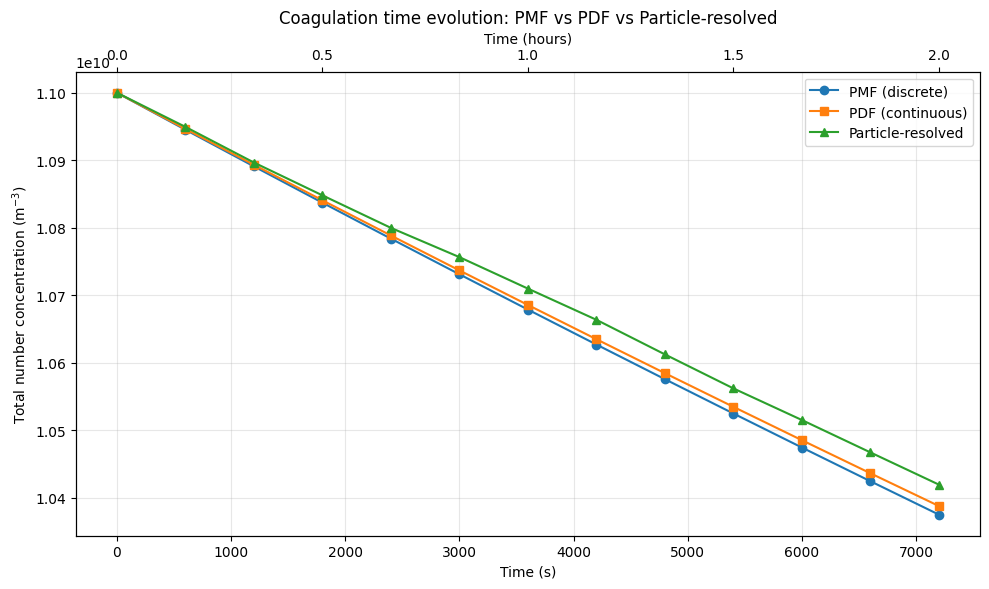

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(
    times,
    number_pmf,
    "o-",
    color="tab:blue",
    label="PMF (discrete)",
    markersize=6,
)
ax.plot(
    times,
    number_pdf,
    "s-",
    color="tab:orange",
    label="PDF (continuous)",
    markersize=6,
)
ax.plot(
    times,
    number_resolved,
    "^-",
    color="tab:green",
    label="Particle-resolved",
    markersize=6,
)

ax.set_xlabel("Time (s)")
ax.set_ylabel(r"Total number concentration (m$^{-3}$)")
ax.set_title("Coagulation time evolution: PMF vs PDF vs Particle-resolved")
ax.legend()
ax.grid(alpha=0.3)

# Add secondary x-axis for time in hours
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(np.arange(0, 7201, 1800))
ax2.set_xticklabels([f"{t / 3600:.1f}" for t in np.arange(0, 7201, 1800)])
ax2.set_xlabel("Time (hours)")

plt.tight_layout()
plt.show()

## Normalized Decay Comparison

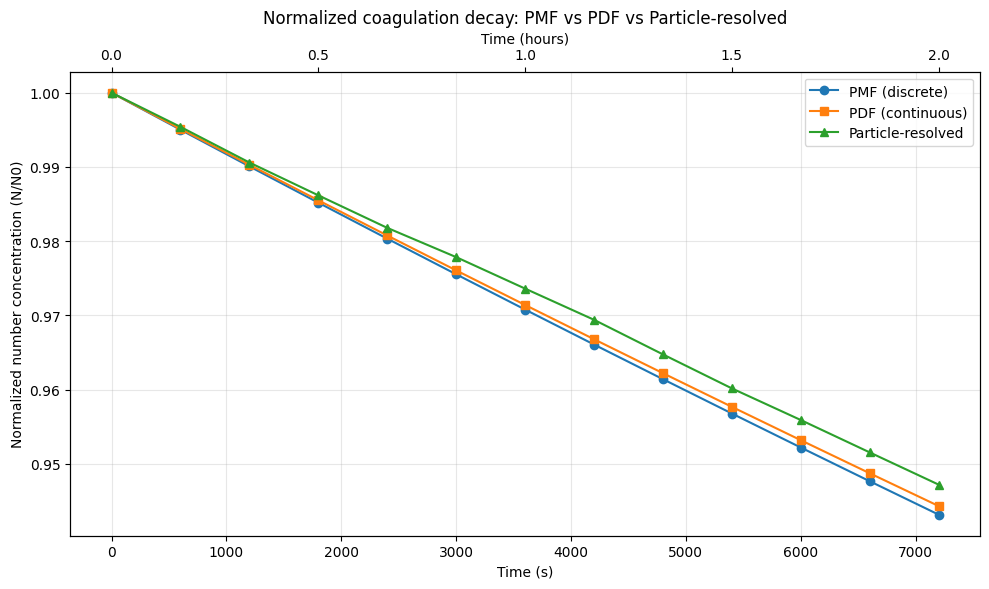


Final concentrations:
  PMF: 1.04e+10 m^-3 (94.3% remaining)
  PDF: 1.04e+10 m^-3 (94.4% remaining)
  Resolved: 1.04e+10 m^-3 (94.7% remaining)


In [11]:
# Normalize to initial concentration for easier comparison
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(
    times,
    number_pmf / number_pmf[0],
    "o-",
    color="tab:blue",
    label="PMF (discrete)",
    markersize=6,
)
ax.plot(
    times,
    number_pdf / number_pdf[0],
    "s-",
    color="tab:orange",
    label="PDF (continuous)",
    markersize=6,
)
ax.plot(
    times,
    number_resolved / number_resolved[0],
    "^-",
    color="tab:green",
    label="Particle-resolved",
    markersize=6,
)

ax.set_xlabel("Time (s)")
ax.set_ylabel("Normalized number concentration (N/N0)")
ax.set_title("Normalized coagulation decay: PMF vs PDF vs Particle-resolved")
ax.legend()
ax.grid(alpha=0.3)

# Add secondary x-axis for time in hours
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(np.arange(0, 7201, 1800))
ax2.set_xticklabels([f"{t / 3600:.1f}" for t in np.arange(0, 7201, 1800)])
ax2.set_xlabel("Time (hours)")

plt.tight_layout()
plt.show()

# Print final values
print("\nFinal concentrations:")
pmf_pct = 100 * number_pmf[-1] / number_pmf[0]
pdf_pct = 100 * number_pdf[-1] / number_pdf[0]
res_pct = 100 * number_resolved[-1] / number_resolved[0]
print(f"  PMF: {number_pmf[-1]:.2e} m^-3 ({pmf_pct:.1f}% remaining)")
print(f"  PDF: {number_pdf[-1]:.2e} m^-3 ({pdf_pct:.1f}% remaining)")
print(f"  Resolved: {number_resolved[-1]:.2e} m^-3 ({res_pct:.1f}% remaining)")

## Summary

This notebook compared the time evolution of total number concentration
for three coagulation representations:

- **PMF (discrete)**: Total number is the sum of bin concentrations
- **PDF (continuous)**: Total number requires integration over the
  distribution
- **Particle-resolved**: Total number is the particle count divided by
  the sample volume

Key observations:

1. **All three representations agree**: At the same initial concentration
   (1e10 m^-3), all three approaches show similar decay rates, validating
   the consistency of the coagulation implementations.

2. **Coagulation rate scaling**: Coagulation rate scales with n^2 (number
   concentration squared), so high concentrations like 1e10 m^-3 show
   significant particle loss over 2 hours.

3. **Use cases**:
   - PMF: Efficient bin-based representation, good for most applications
   - PDF: Continuous representation, useful for smooth distributions
   - Particle-resolved: Best for tracking individual particle properties
     (e.g., composition mixing state) but computationally more expensive